In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
from pprint import pprint as pp
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow
from tqdm.auto import tqdm

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSM_splot, FSM_add_Notations, FSM_add_Alarms, FSM_add_Warnings, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left, cvset, load_data, get_cycle_data, get_cycle_data2)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations();

In [2]:
def sfun(x):
    return all([ ("Forsa Hartmoor" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
    #return all([ ("Pforzheim" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
    #return all([ ("BMW Landshut 4.10" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T

,0,1,2,3,4,5,6,7,8,9,10
Count_OpHour,213.0,212.0,201.0,193.0,207.0,213.0,199.0,183.0,186.0,149.0,185.0
OperationalCondition,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available
shutdown_counter,150.0,118.0,111.0,111.0,112.0,110.0,104.0,97.0,104.0,95.0,106.0
startup_counter,150.0,117.0,112.0,112.0,112.0,109.0,105.0,98.0,105.0,94.0,102.0
id,159396,159397,159399,159398,159400,159401,159403,159402,159404,159405,159406
Engine Version,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12
Engine Type,624,624,624,624,624,624,624,624,624,624,624
Engine Series,6,6,6,6,6,6,6,6,6,6,6
Country,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB
Commissioning Date,2022-01-10,2022-01-10,2022-01-11,2022-01-11,2022-01-22,2022-01-10,2022-01-11,2022-01-11,2022-01-11,2022-01-22,2022-01-11


In [3]:
motor = fleet.iloc[0]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success
e=Engine.from_fleet(mp,motor)
#fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to='2019-01-16', successtime=300)
#fsm = msgFSM(e, p_to='2022-02-01', successtime=600)
#fsm = msgFSM(e, p_from='2022-01-26', p_to='2022-02-01', successtime=600)
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), successtime=300)

In [4]:
fsm.run1(enforce=False, silent=False) # run Finite State Machine
#fsm.store()

FSM: 100%|█████████████████████████| 7726/7726 [00:01<00:00, 5102.16 messages/s]


In [5]:
fsm.run2();

FSM Run2: 100%|██████████████████████████| 129/129 [01:38<00:00,  1.31 starts/s]


In [6]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 129, Successful: 69, Failed: 60 => 53.5%


In [7]:
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,False,???,102.47,4.24,22.68,61.0,,,190.39,,,,,,,0,0
1,1,True,???,93.11,4.14,20.57,6.25,54.96,125.64,304.67,4487.23,0.79,738.89,126.78,10.01,50.62,0,0
2,2,True,???,0.61,4.04,18.18,4.34,45.72,162.97,235.85,4447.3,0.61,3136.3,126.89,10.01,50.42,0,1
3,3,True,???,60.61,3.64,18.9,5.56,48.25,126.31,263.27,4464.71,0.79,14587.95,127.07,9.99,50.53,0,0
4,4,True,???,96.44,4.13,20.02,5.77,45.56,126.6,298.52,4468.86,0.78,2973.37,127.07,10.01,50.46,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,124,True,AUTO,102.09,3.84,22.61,4.64,2.01,140.98,276.18,4500.0,0.7,7223.21,126.92,10.0,50.83,0,0
125,125,True,AUTO,97.74,3.83,19.9,4.44,62.37,88.71,276.99,4492.7,1.12,12620.83,126.8,9.99,50.73,0,0
126,126,False,AUTO,101.98,3.63,23.0,4.54,61.97,33.83,228.95,2006.46,1.38,,0.3,45.02,,1,1
127,127,False,AUTO,93.00,3.84,20.83,4.44,43.75,110.45,276.31,4454.77,0.9,112.81,126.9,9.97,50.55,0,0


In [8]:
#test for failures
rdd = rda[rda['loadramp'] < 0.0]
rdd[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings


In [9]:
rdb = rda
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,speedup,idle,synchronize,loadramp,targetload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,129.00,100.00,96.00,95.00,94.00,94.00,94.00,129.00,78.00,94.00,94.00,93.00
mean,110.58,20.60,7.15,26.49,110.84,3954.08,0.95,235.20,6482.22,110.41,10.37,50.11
std,103.98,2.61,9.33,22.94,42.85,1182.41,0.46,129.19,6663.48,36.96,3.61,1.76
min,0.61,8.06,4.03,1.00,13.42,635.83,0.52,2.62,9.39,0.30,9.92,41.64
25%,73.21,18.57,4.51,5.10,90.30,4448.22,0.71,190.39,1647.15,126.69,9.99,50.36
50%,99.27,20.43,4.75,10.62,125.67,4476.56,0.79,275.79,3623.54,126.86,9.99,50.54
75%,104.40,22.69,5.66,46.21,139.25,4491.71,1.00,277.00,10772.38,126.96,10.01,50.85
max,828.72,27.04,61.00,95.90,187.69,4518.72,2.61,881.09,32524.34,127.32,45.02,52.22


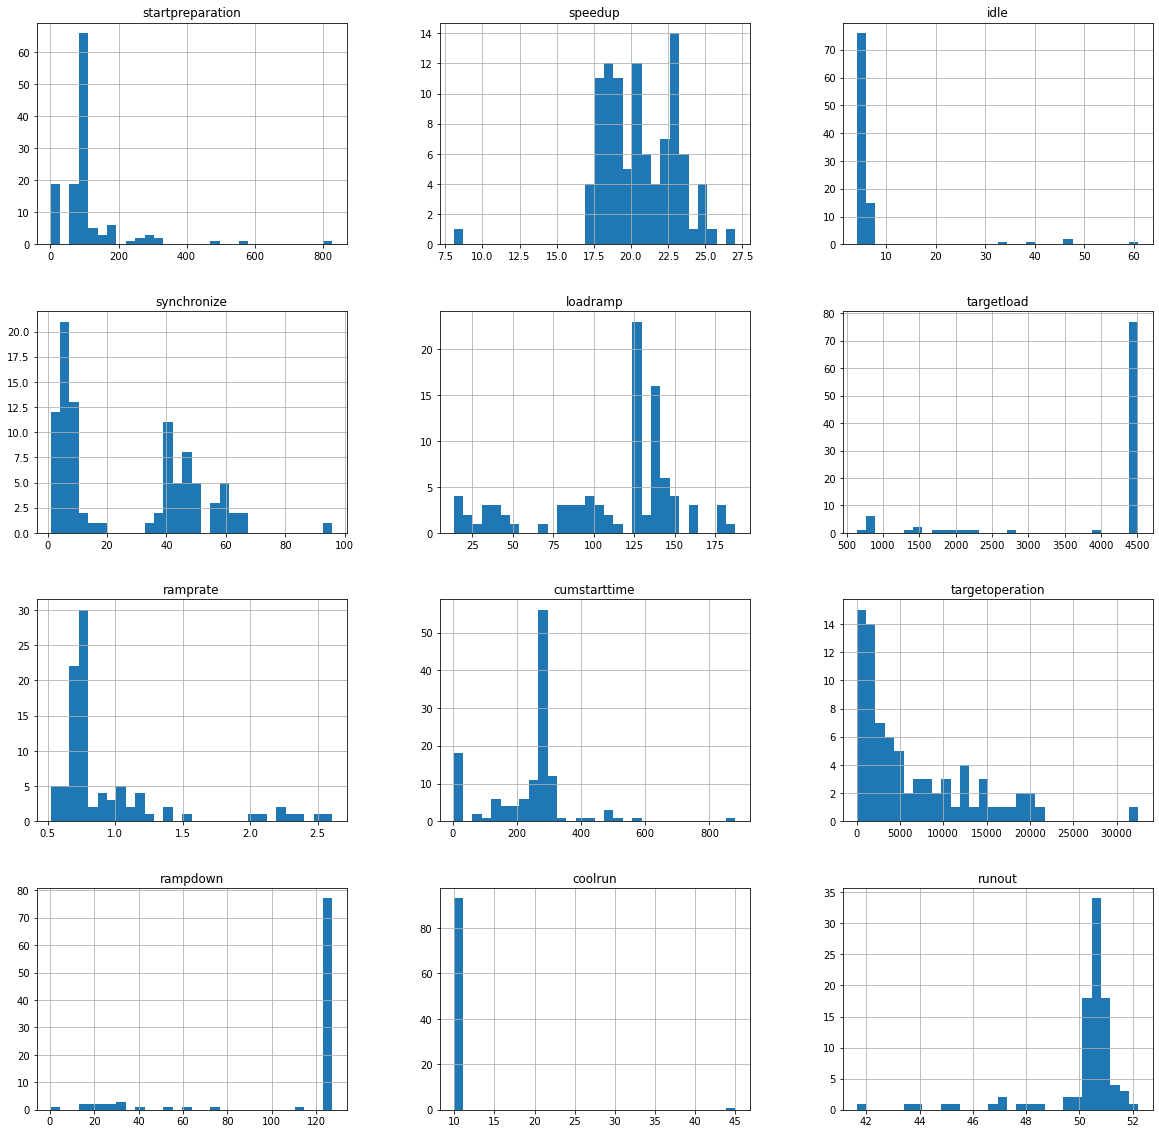

In [10]:
vec = ['startpreparation','speedup','idle','synchronize','loadramp','targetload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [11]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (18,12)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,1200)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['targetload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)

In [31]:
#vset = ['Various_Values_SpeedAct','Power_PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red', 'unit':'kW'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue', 'unit':'rpm'},
    {'col':['TecJet_Lambda1'],'ylim': [0, 3], 'color':'orange', 'unit':'-'},
    {'col':['Various_Values_PosThrottle','Various_Values_PosTurboBypass'],'ylim': [0, 100], 'color':['hotpink','brown'], 'unit':'%'},
    #{'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange', 'unit':'mbar'},
    #{'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black', 'unit': 'bar'},
    #{'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown', 'unit': 'bar'},
    #{'col':['Hyd_TempOil','Hyd_TempCoolWat','Hyd_TempWatRetCoolOut'],'ylim': [0, 110], 'color':['#2171b5','orangered','hotpink'], 'unit':'°C'},
]
vset = cvset(mp,dset)

In [14]:
def f(x=0):
    global vv; vv = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='90%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='90%'), max=128), Output()), _do…

In [32]:
startversuch = rdb.iloc[vv]; 
#startversuch = rdb.iloc[900]; 

# download myplant data
data = get_cycle_data2(fsm, startversuch, max_length=None, min_length=None, cycletime=1, silent=True, p_data=cvset(mp,dset))

# calculated data
data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))

fig = FSM_splot(fsm, startversuch, data, dset, figsize=(16,8))
fig = FSM_add_Notations(fig, fsm, startversuch)
bokeh_show(fig)

von: 28.02.2022 17:47:41 bis: 28.02.2022 19:33:12


In [33]:
def f(x=0):
    global vvv; vvv = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='90%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='90%'), max=128), Output()), _do…

In [34]:
import bokeh
from bokeh.models import ColumnDataSource, Label, Text, Span, HoverTool #, Range1d#, LabelSet
from bokeh.plotting import figure, output_file, show

#startversuch = rdb.iloc[vvv];
periodfactor = 1.5 # times calculated period length
helplinefactor = 0.8 # overlay slope to -fac * end value 
#interestingcycles = [0,1,8, 62, 65, 76, 77, 80, 95, 96, 97, 98, 99, 252, 678] # BMW Landshut M4
interestingcycles = [117] # Forsa Hartmoor M1
#interestingcycles = [0,64, 66, 82] # Forsa Hartmoor M4
#interestingcycles = [0] # Pforzheim M4
#interestingcycles = [17] #
disp_result(rdb.iloc[interestingcycles[0]])

no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
117,True,AUTO,166.176999,3.532999,8.064,4.743,49.062,47.380999,278.959997,4464.944,2.098032,5865.124999,126.842,10.076999,50.856,0,0


In [37]:
import time
import dmyplant2
dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
         {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}]
ratedload = fsm._e['Power_PowerNominal']
for i in interestingcycles: 
    startversuch=rdb.iloc[i]
    sno = startversuch['no']
    data, xmax, ymax, duration, ramprate = dmyplant2.loadramp_edge_detect(fsm,startversuch)
    if not data.empty:
        print(f"Start: {startversuch['no']:3d} xmax: {xmax}, ymax: {ymax:6.0f}, duration: {duration:5.1f}, ramprate: {ramprate / ratedload * 100.0:4.2f} %/s")
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
        fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(14,6))
        fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
        fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig = FSM_add_Notations(fig, fsm, startversuch)
        #fig = FSM_add_Alarms(fig, fsm, startversuch)
        #fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    else:
        print(f"Start: {startversuch['no']:3d} no data, no improvement possible.")

Start: 117 xmax: 2022-02-28 17:52:20, ymax:   4465, duration:  47.3, ramprate: 2.10 %/s
von: 28.02.2022 17:47:41 bis: 28.02.2022 19:33:12


In [ ]:
import time
dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
         {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}]
ratedload = fsm._e['Power_PowerNominal']
t0 = time.time()
for i, startversuch in rdb[-3:].iterrows() : 
#for i, startversuch in tqdm(rdb.iterrows(), total=rdb.shape[0], ncols=80, mininterval=1, unit=' starts', desc="FSM Run2"):
    data, xmax, ymax, duration, ramprate = loadramp_edge_detect(startversuch)
    if not data.empty:
        print(f"Start: {startversuch['no']:3d} xmax: {xmax}, ymax: {ymax:6.0f}, duration: {duration:5.1f}, ramprate: {ramprate / ratedload * 100.0:4.2f} %/s")
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
        fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(14,6))
        fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
        fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig = FSM_add_Notations(fig, fsm, startversuch)
        #fig = FSM_add_Alarms(fig, fsm, startversuch)
        #fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    else:
        print(f"Start: {startversuch['no']:3d} no data, no improvement possible.")
t1 = time.time()
print(f"{(t1-t0):4.1f} sec")    

In [ ]:
from dowork import plot_plotly
fig2 = plot_plotly(fsm, data, startversuch, cvset(mp,dset), dset, dfigsize=(15,9))
fig2.show(config={'scrollZoom': True})

In [ ]:
fsm.starts.iloc[vv].to_dict();

In [ ]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=True)):
    print(f"{i:3} {v}")

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)